In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bitcoin

dados historicos

In [73]:
data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
data = data[['Close']].dropna()

[*********************100%***********************]  1 of 1 completed


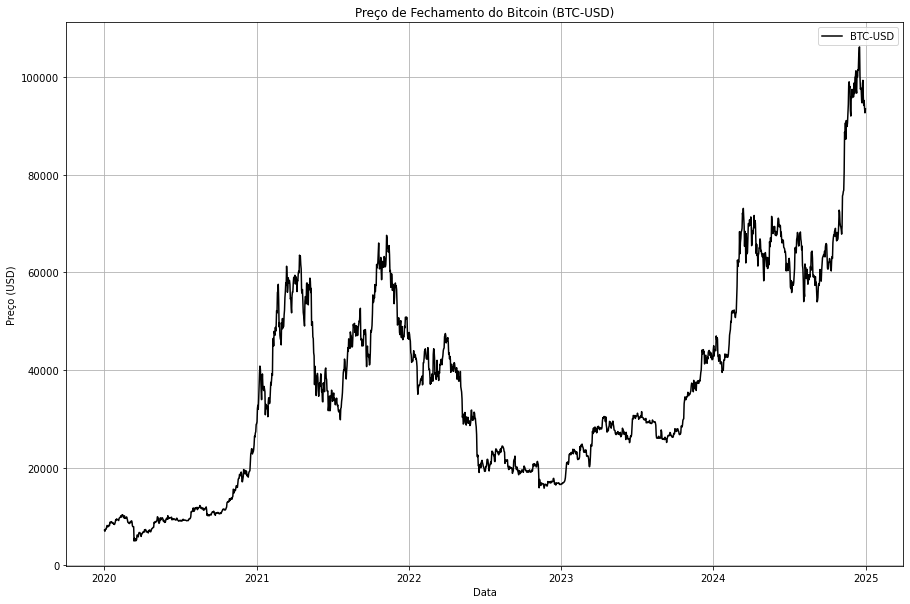

In [74]:
plt.figure(figsize=(15, 10)) 
plt.plot(data['Close'], label='BTC-USD', color='black', alpha=1)
plt.title('Preço de Fechamento do Bitcoin (BTC-USD)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

O preço do Bitcoin possui fortes tendências de alta e baixa, o que torna-o instável. Além disso, existem longos momentos  de lateralização, especialmente por volta de 2023. E, recentemente, há um movimento bem expressivo de explosão de preço.

Dessa forma, a estratégia de cruzamento de médias móveis funciona bem quando a tendência é forte. Porém, ela não funciona bem em lateralizações, pois ocorrem oscilações de preço sem direções claras, ocorrendo, portanto, "falsos sinais". 

Vamos iniciar o projeto com o cálculo de duas médias móveis: uma a curto prazo (20 períodos) e uma a longo prazo (200 períodos). Depois, um estudo de sensibilidade será feito a fim de estudar ver quais são mais lucrativos ao longo do tempo. E por último combinar técnicas para enfim estudar sua sensibilidade.

## EMA longo e curto prazo

### Cálculo das Médias Móveis (EMAs)

In [75]:
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

### Sinais de Compra/Venda

In [76]:
# Gera sinais de compra (1) e venda (0)
data['Signal'] = 0
data.loc[data['EMA20'] > data['EMA200'], 'Signal'] = 1
data.loc[data['EMA20'] < data['EMA200'], 'Signal'] = -1
data['Position'] = data['Signal'].diff()


### Lógica de Alocação e Backtesting

In [77]:
data['Return'] = (data['Close'] / data['Close'].shift(1))
data['Strategy'] = data['Signal'].shift(1) * data['Return']

In [78]:
buy_signals = data[data['Position'] == 2]
sell_signals = data[data['Position'] == -2]

### Visualização dos Resultados

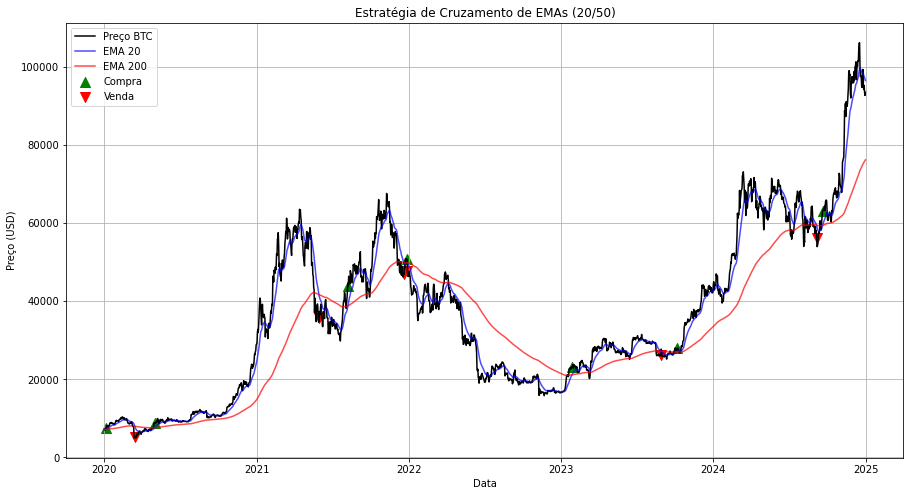

In [79]:
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], label='Preço BTC', color='black')
plt.plot(data['EMA20'], label='EMA 20', color='blue', alpha=0.7)
plt.plot(data['EMA200'], label='EMA 200', color='red', alpha=0.7)
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Compra', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Venda', s=100)
plt.title('Estratégia de Cruzamento de EMAs (20/50)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

###  Avaliação do desempenho da estratégia no tempo

In [82]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def run_backtest(start_date, end_date, ema_short=20, ema_long=200):
    data = yf.download('BTC-USD', start=start_date, end=end_date)[['Close']].dropna()
    data['EMA_Short'] = data['Close'].ewm(span=ema_short, adjust=False).mean()
    data['EMA_Long'] = data['Close'].ewm(span=ema_long, adjust=False).mean()

    data['Signal'] = 0
    data.loc[data['EMA_Short'] > data['EMA_Long'], 'Signal'] = 1
    data.loc[data['EMA_Short'] < data['EMA_Long'], 'Signal'] = -1
    data['Return'] = data['Close'] / data['Close'].shift(1)
    data['Strategy'] = data['Signal'].shift(1) * data['Return']

    strategy_return = data['Strategy'].cumprod().iloc[-1]
    buy_and_hold = data['Return'].cumprod().iloc[-1]

    return strategy_return, buy_and_hold, data

# Períodos diferentes para teste
periods = [
    ('2020-01-01', '2021-01-01'),
    ('2021-01-01', '2022-01-01'),
    ('2022-01-01', '2023-01-01'),
    ('2023-01-01', '2024-01-01'),
    ('2024-01-01', '2025-01-01')
]

for start, end in periods:
    strat, hold, _ = run_backtest(start, end)
    print(f"{start} até {end}: Estratégia = {strat:.2f} | Buy & Hold = {hold:.2f}")


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

2020-01-01 até 2021-01-01: Estratégia = 0.00 | Buy & Hold = 4.03
2021-01-01 até 2022-01-01: Estratégia = 0.00 | Buy & Hold = 1.58
2022-01-01 até 2023-01-01: Estratégia = -0.00 | Buy & Hold = 0.35


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



2023-01-01 até 2024-01-01: Estratégia = -0.00 | Buy & Hold = 2.54
2024-01-01 até 2025-01-01: Estratégia = -0.00 | Buy & Hold = 2.12


###  Avaliação do desempenho da estratégia por parâmetro

In [ ]:
def run_backtest(start_date, end_date, ema_short, ema_long):
    data = yf.download('BTC-USD', start=start_date, end=end_date)[['Close']].dropna()
    data['EMA_Short'] = data['Close'].ewm(span=ema_short, adjust=False).mean()
    data['EMA_Long'] = data['Close'].ewm(span=ema_long, adjust=False).mean()

    data['Signal'] = 0
    data.loc[data['EMA_Short'] > data['EMA_Long'], 'Signal'] = 1
    data.loc[data['EMA_Short'] < data['EMA_Long'], 'Signal'] = -1
    data['Return'] = data['Close'] / data['Close'].shift(1)
    data['Strategy'] = data['Signal'].shift(1) * data['Return']

    strategy_return = data['Strategy'].cumprod().iloc[-1]
    buy_and_hold = data['Return'].cumprod().iloc[-1]
    
    return strategy_return, buy_and_hold

# Parâmetros a testar
short_emas = [10, 20, 30, 50]
long_emas = [100, 150, 200, 250]

# Período fixo para teste
start_date = '2020-01-01'
end_date = '2025-01-01'

# Armazenar os resultados
results = []

for short in short_emas:
    for long in long_emas:
        if short < long:  # Garante que a EMA curta seja menor que a longa
            strat, hold = run_backtest(start_date, end_date, short, long)
            results.append({
                'EMA_Curta': short,
                'EMA_Longa': long,
                'Retorno_Estrategia': round(strat, 2),
                'Retorno_Buy_Hold': round(hold, 2)
            })

# Exibir resultados em tabela
df_resultados = pd.DataFrame(results)
print(df_resultados.sort_values(by='Retorno_Estrategia', ascending=False))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

    EMA_Curta  EMA_Longa  Retorno_Estrategia  Retorno_Buy_Hold
0          10        100                 0.0             12.98
1          10        150                 0.0             12.98
2          10        200                -0.0             12.98
3          10        250                 0.0             12.98
4          20        100                 0.0             12.98
5          20        150                 0.0             12.98
6          20        200                -0.0             12.98
7          20        250                 0.0             12.98
8          30        100                 0.0             12.98
9          30        150                 0.0             12.98
10         30        200                 0.0             12.98
11         30        250                -0.0             12.98
12         50        100                 0.0             12.98
13         50        150                -0.0             12.98
14         50        200                 0.0           

Conclusão: Pelos testes de sensibilidade, as estratégias de cruzamento de EMAs não funcionaram bem com nenhum dos períodos testados nesse intervalo de tempo. Portanto, vamos testar outra estratégia mais complexa, já que esta ficou praticamente parada em comparação com buy e hold.

Como há, historicamente, uma volatilização do preço, vamos fazer uma estratégia que indique o melhor momento de compra de acordo com a sua volatilidade. Isso será utlizado para realizar compra quando a volatilidade está acima de uma média histórica, a fim de evitae a operação em períodos de baixa volatilidade.

## Lógica ATR

Compra: EMA Curta > EMA Longa e ATR > Média ATR (últimos 20 dias)

Venda: EMA Curta < EMA Longa ou ATR <= Média ATR

In [85]:
data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
data = data[['Close', 'High', 'Low']].dropna()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

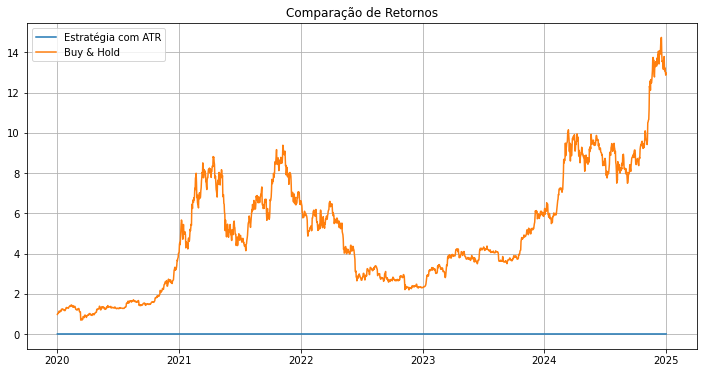

In [ ]:
# Baixando os dados
data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
data = data[['Close', 'High', 'Low']].dropna()

# Calcula EMAs
data['EMA_Short'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_Long'] = data['Close'].ewm(span=200, adjust=False).mean()

# Calcula ATR (Average True Range)
high_low = data['High'] - data['Low']
high_close = abs(data['High'] - data['Close'].shift(1))
low_close = abs(data['Low'] - data['Close'].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data['ATR'] = true_range.rolling(window=14).mean()

data.columns = data.columns.droplevel(1)

buy_condition = (data['EMA_Short'] > data['EMA_Long']) & (data['Close'] > data['EMA_Long'] + data['ATR'] * 1.5)
sell_condition = (data['EMA_Short'] < data['EMA_Long']) | (data['Close'] < data['EMA_Long'] - data['ATR'] * 1.5)

data.loc[buy_condition, 'Signal'] = 1
data.loc[sell_condition, 'Signal'] = 0

# Posição ao longo do tempo (carrega último valor válido)
data['Position'] = data['Signal'].ffill().fillna(0)

# Retorno da estratégia
data['Return'] = data['Close'] / data['Close'].shift(1)
data['Strategy'] = data['Position'].shift(1) * data['Return']

# Cumulativo
data['Cumulative_Strategy'] = data['Strategy'].cumprod()
data['Cumulative_Buy_Hold'] = data['Return'].cumprod()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy'], label='Estratégia com ATR')
plt.plot(data['Cumulative_Buy_Hold'], label='Buy & Hold')
plt.title('Comparação de Retornos')
plt.legend()
plt.grid(True)
plt.show()


In [95]:
data

Price,Close,High,Low,EMA_Short,EMA_Long,ATR,Signal,Position,Return,Strategy,Cumulative_Strategy,Cumulative_Buy_Hold
Date,,,,,,,,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7200.174316,7200.174316,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-02,6985.470215,7212.155273,6935.270020,7179.726307,7198.037957,NaN,0.0,0.0,0.970181,0.000000,0.0,0.970181
2020-01-03,7344.884277,7413.715332,6914.996094,7195.455637,7199.499115,NaN,0.0,0.0,1.051452,0.000000,0.0,1.020098
2020-01-04,7410.656738,7427.385742,7309.514160,7215.950980,7201.600185,NaN,NaN,0.0,1.008955,0.000000,0.0,1.029233
2020-01-05,7411.317383,7544.497070,7400.535645,7234.557304,7203.686924,NaN,NaN,0.0,1.000089,0.000000,0.0,1.029325
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,94164.859375,97294.843750,93310.742188,97801.842291,75447.455595,4255.483259,1.0,1.0,0.982978,0.982978,0.0,13.078136
2024-12-28,95163.929688,95525.898438,94014.289062,97550.612519,75643.639417,4221.681920,1.0,1.0,1.010610,1.010610,0.0,13.216892
2024-12-29,93530.226562,95174.875000,92881.789062,97167.718619,75821.615409,4112.580357,1.0,1.0,0.982833,0.982833,0.0,12.989995


In [90]:
print(data[['Signal', 'EMA_Short', 'EMA_Long', 'ATR']].tail(10))


Price      Signal     EMA_Short      EMA_Long          ATR
Ticker                                                    
Date                                                      
2024-12-22      0  98692.014312  74367.219442  4418.834263
2024-12-23      0  98310.512205  74569.398773  4211.440290
2024-12-24      0  98345.329495  74809.266385  4354.808036
2024-12-25      0  98436.173858  75052.947270  4049.032924
2024-12-26      0  98184.682598  75259.340985  4160.584821
2024-12-27      0  97801.842291  75447.455595  4255.483259
2024-12-28      0  97550.612519  75643.639417  4221.681920
2024-12-29      0  97167.718619  75821.615409  4112.580357
2024-12-30      0  96736.813125  75988.994469  4050.337054
2024-12-31      0  96421.802649  76162.528883  4136.041295


In [91]:
data['Close'] > data['EMA_Long'] + data['ATR'] * 1.5


ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.